# Tarea 1 Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Matías Rojas
Fecha de entrega: 20 de agosto de 2019

In [0]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [0]:
# Definición de la función sigmoide.

def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

# Definición de la tangente hiperbólica como ejemplo de función de activación.
def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

# Definición de la función relu.
def relu(T):
  return torch.clamp(T,min=0)

#Definición de la función swish.
def swish(T, beta):
  return T*sig(beta*T)

#Definición de l función celu.
def celu(T, alpha):
  T[T<0]=alpha*(torch.exp(T[T<0]/alpha) - 1)
  return T


## 1b) Softmax

(La demostración puedes entregarla en otro archivo o incluirla directamente acá)

In [0]:
# Demostración:
# Queremos demostrar que: softmax(x_1-M, x_2-M, ... , x_n - M) = softmax(x_1, x_2, ... , x_n)
# En efecto, softmax(x_1-M, x_2-M, ... , x_n - M) = (s_1, s_2, ... , s_n) = (e^(x_1-M) / sum(e^(x_j-M)), e^(x_2-M) / sum(e^(x_j-M)), ... , e^(x_n-M) / sum(e^(x_j-M))) 
# Pero como en el denominador y el numerador se puede factorizar por e^-M ya que no depende del índice de la sumatoria, entonces podemos simplificar quedando:
# (e^x_1 / sum(e^x_j), e^x_2 / sum(e^x_j), ... , e^x_n / sum(e^x_j)) = softmax(x_1, x_2 , ... , x_n), que es a lo que queríamos llegar.

def softmax(T, dim, estable=True):
  if estable:
    max = torch.max(T,dim,keepdim=True)[0]
    num = torch.exp(T-max)
    den = torch.sum(num,dim,keepdim=True)
    result = torch.div(num,den)
  else:
    num = torch.exp(T)
    den = torch.sum(num,dim,keepdim=True)
    result = torch.div(num,den)
  return result
  

# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [0]:


class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C, input=None):
    super(FFNN, self).__init__()
    self.listfunctions = l_a
    self.nhiddenlayers = len(l_h)
    self.weight = [0]*(self.nhiddenlayers+1)
    self.bias = [0]*(self.nhiddenlayers+1)
    self.parameterList = torch.nn.ParameterList([])
    self.input = input 
    self.F = F
    self.U = None
    self.c = None 
    
    if input!=None:
      for i in range(0,len(self.input[0])-1):
        self.weight[i]=self.input[0][i]
        self.bias[i]=self.input[1][i]
        self.parameterList.append(torch.nn.Parameter(self.bias[i]))
        self.parameterList.append(torch.nn.Parameter(self.weight[i]))  
      self.U = self.input[0][-1]
      self.c = self.input[1][-1]
      self.parameterList.append(torch.nn.Parameter(self.U))
      self.parameterList.append(torch.nn.Parameter(self.c))  
      
    else:
      bias = [0]*(self.nhiddenlayers) 
      weight = [0]*(self.nhiddenlayers)
      bias[0] = torch.zeros(1,l_h[0])
      weight[0] = torch.rand(F,l_h[0])
      self.parameterList.append(torch.nn.Parameter(bias[0]))
      self.parameterList.append(torch.nn.Parameter(weight[0]))
      
      for i in range(1,self.nhiddenlayers):
        bias[i] = torch.zeros(1,l_h[i])
        weight[i] = torch.rand(l_h[i-1],l_h[i])
        self.parameterList.append(torch.nn.Parameter(bias[i]))
        self.parameterList.append(torch.nn.Parameter(weight[i]))

      self.c = torch.zeros(1,C)
      self.U = torch.rand(l_h[self.nhiddenlayers-1],C)
      self.parameterList.append(torch.nn.Parameter(self.U))
      self.parameterList.append(torch.nn.Parameter(self.c))
      
        
  def resumen(self):
    for indice,tensor in self.named_parameters():
      print("Parametro n°: ", indice, " con un tensor de dimensiones ", tensor.size())
    
    for tensor in self.parameters():
      print(tensor)
       
  def forward(self, x):

    h = [None]*(self.nhiddenlayers)
    x = x.view(-1,self.F)
    h[0] = self.listfunctions[0](x.mm(self.parameterList[1]).add(self.parameterList[0]))
    for i in range(1,self.nhiddenlayers):
      h[i] = self.listfunctions[i](h[i-1].mm(self.parameterList[i+2]).add(self.parameterList[i+1]))
    y = softmax(h[self.nhiddenlayers-1].mm(self.parameterList[-2]).add(self.parameterList[-1]),1)    
    return y
  
  


## 2c) Moviendo los parámetros entre dispositivos

In [0]:
def moveToGpu(red_neuronal):
    red_neuronal.cuda()
  
def moveToCpu(red_neuronal):
    red_neuronal.cpu()  
  

red_neuronal =  FFNN(784,[32,16],[relu,relu],10)
moveToGpu(red_neuronal)
print(red_neuronal)
moveToCpu(red_neuronal)
print(red_neuronal)

red_neuronal.resumen()

FFNN(
  (parameterList): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 1x32 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 784x32 (GPU 0)]
      (2): Parameter containing: [torch.cuda.FloatTensor of size 1x16 (GPU 0)]
      (3): Parameter containing: [torch.cuda.FloatTensor of size 32x16 (GPU 0)]
      (4): Parameter containing: [torch.cuda.FloatTensor of size 16x10 (GPU 0)]
      (5): Parameter containing: [torch.cuda.FloatTensor of size 1x10 (GPU 0)]
  )
)
FFNN(
  (parameterList): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 1x32]
      (1): Parameter containing: [torch.FloatTensor of size 784x32]
      (2): Parameter containing: [torch.FloatTensor of size 1x16]
      (3): Parameter containing: [torch.FloatTensor of size 32x16]
      (4): Parameter containing: [torch.FloatTensor of size 16x10]
      (5): Parameter containing: [torch.FloatTensor of size 1x10]
  )
)
Parametro n°:  parameterList.0

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

0it [00:00, ?it/s]

9920512it [00:01, 8440624.06it/s]                            


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135608.24it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2211586.12it/s]                            
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 50533.41it/s]            


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Cantidad total de datos: 10000
Tensor
tipo: torch.FloatTensor
dimensiones: torch.Size([1, 28, 28])

Entero
valor: 7


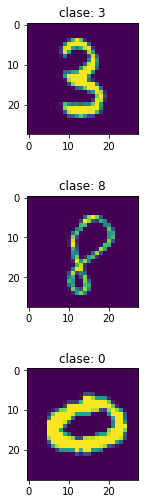

In [0]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from matplotlib.pyplot import subplots
from random import randint
import random


# ESTE CODIGO ES SOLO PARA VER TODAS LAS COSAS QUE HAY EN MNIST

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', train=False, transform=ToTensor(),download=True)
print('Cantidad total de datos:',len(dataset))
T, l = dataset[0]

print('Tensor')
print('tipo:', T.type())
print('dimensiones:', T.size())
print()
print('Entero')
print('valor:', l)

n_ejemplos = 3
fig, axs = subplots(nrows=n_ejemplos, figsize=(2,n_ejemplos*3))

for i in range(n_ejemplos):  
  idx = random.randint(0,len(dataset))
  T, l = dataset[idx]
  img = T.view(28,28).numpy()
  axs[i].set_title("clase: "+ str(l))
  axs[i].imshow(img)
  

## 3b) Cargando los parámetros pre-entrenados

In [0]:
import numpy as np
!git clone https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile.git
  
W1 = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/W1.txt")).float()
W2 = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/W2.txt")).float()
b1 = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/b1.txt")).float()
b2 = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/b2.txt")).float()
U = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/U.txt")).float()
c = torch.from_numpy(np.loadtxt("/content/cc6204-DeepLearning-DCCUChile/2019/tareas/tarea1/mnist_weights/c.txt")).float()
input = [[W1,W2,U],[b1,b2,c]]
red_neuronal =  FFNN(784,[32,16],[relu,relu],10, input)


Cloning into 'cc6204-DeepLearning-DCCUChile'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 5693 (delta 0), reused 11 (delta 0), pack-reused 5682
Receiving objects: 100% (5693/5693), 7.19 MiB | 8.61 MiB/s, done.
Resolving deltas: 100% (2740/2740), done.


## 3c) Cálcula la predicción de un ejemplo al azar

Cantidad total de datos: 10000


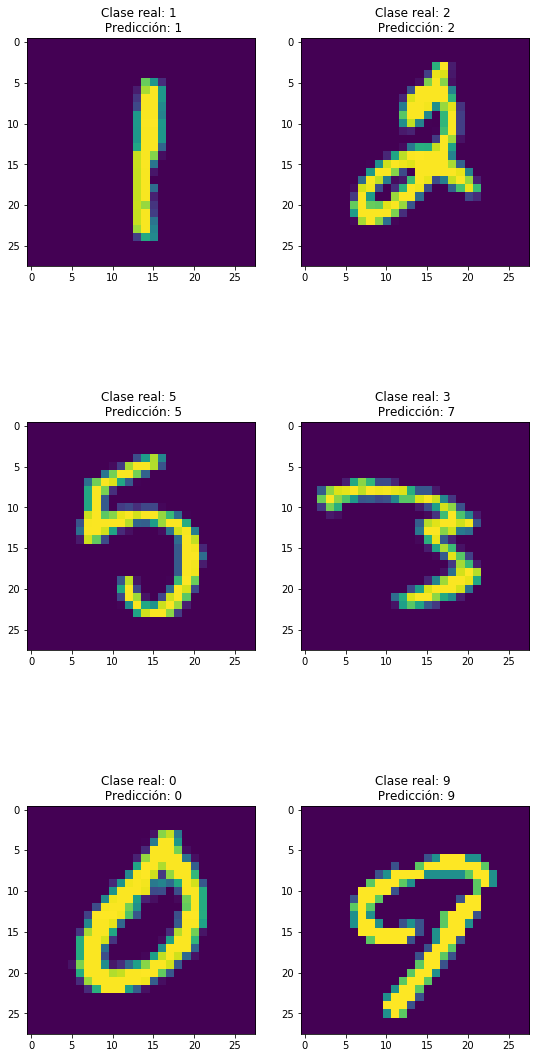

In [0]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from matplotlib.pyplot import subplots
from random import randint
import random
cols = 2
filas = 3
dataset = MNIST('mnist', train=False, transform=ToTensor(),download=True)
print('Cantidad total de datos:',len(dataset))

T, l = dataset[0]

aux = 0
fig, axs = subplots(nrows=filas, ncols = cols, figsize=(3*filas,10*cols))

for i in range(filas):
  for j in range(cols):  
    idx = random.randint(0,len(dataset))
    T, l = dataset[idx]
    img = T.view(28,28).numpy()
    vectorprobabilidades = red_neuronal(T)
    prediccion = vectorprobabilidades.argmax()
    axs[i][j].set_title(f"Clase real: {l} \n Predicción: {prediccion.item()}")
    axs[i][j].imshow(img)
  



## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [0]:
from torch.utils.data import DataLoader
import numpy as np
import statistics
import time

red_neuronal2 =  FFNN(784,[32,16],[relu,relu],10)
equivocaciones = []


def calcula_acierto(red,dataset,batch_size,device):
  dataloader = DataLoader(dataset, batch_size)
  aciertos = 0
  red.to(device)
  start = time.clock()
  errores = 0
  for x, y in dataloader:
    x = x.to(device)
    y = y.to(device)
    result = red.forward(x)
    for indice,softmaxresult in enumerate(result):
      prediccion = softmaxresult.max(0)[1]
      if prediccion == y[indice]:
        aciertos = aciertos + 1
      else:
        if errores < 10:
          equivocaciones.append([x[indice],prediccion.item(), y[indice].item()])
          errores = errores + 1
        
  porcentaje = (aciertos/(len(dataloader)*batch_size))*100
  print("El tiempo total es: ", time.clock()-start, "segundos en", device)
  return porcentaje

print("Red neuronal pre entrenada. ")
porc = calcula_acierto(red_neuronal, dataset,100,'cpu')
print("El porcentaje total de aciertos es: ", porc, "%")

print("Red neuronal con parámetros al azar. ")

porc = calcula_acierto(red_neuronal2, dataset,100,'cuda')
print("El porcentaje total de aciertos es: ", porc, "%")



Red neuronal pre entrenada. 
El tiempo total es:  1.3748430000000003 segundos en cpu
El porcentaje total de aciertos es:  96.12 %
Red neuronal con parámetros al azar. 
El tiempo total es:  2.2150370000000006 segundos en cuda
El porcentaje total de aciertos es:  10.280000000000001 %


## 3e) Opcional: Muestra los casos en donde la red se equivoca

La predicción fue:  6
Pero su clase real era:  5
La predicción fue:  8
Pero su clase real era:  9
La predicción fue:  2
Pero su clase real era:  4
La predicción fue:  0
Pero su clase real era:  6
La predicción fue:  7
Pero su clase real era:  9
La predicción fue:  7
Pero su clase real era:  2


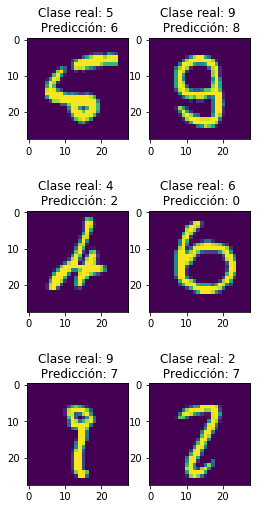

In [0]:
columnas = 2
filas = 3
fig, axs = subplots(nrows=filas, ncols=columnas, figsize=(2*columnas, 3*filas))
aux = 0 

for i in range(filas): 
  for j in range(columnas):
    print("La predicción fue: ", equivocaciones[aux][1])
    print("Pero su clase real era: ", equivocaciones[aux][2])
    img = equivocaciones[aux][0].view(28,28).cpu().numpy()
    axs[i][j].set_title(f"Clase real: {equivocaciones[aux][2]} \n Predicción: {equivocaciones[aux][1]}")
    axs[i][j].imshow(img)
    aux = aux + 1
  

# Si es razonable que se cometan estos errores debido a que las matrices representan
# números muy parecidos a los que fueron predecidos por la red. Esto se debe 
# o bien a una imagen distorsionada o a terminaciones parecidas entre dos o más números.
# Para ejemplificar, en la primera imagen en la clase real se aprecia un 5 pero la predicción
# fue un 6, en la imagen se puede ver que se asemeja a un 6 pero con la parte inferior más pequeña.
# Por ejemplo para el último caso, la red predice que es un 7 cuando en realidad era un 9, esto
# debido a que la parte superior del 9, el "agujero" apenas se aprecia, formando un número
# similar al 7.

 

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [0]:
import torchvision
from torch.utils.data import DataLoader

from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import string
import random
import os

letters = string.ascii_lowercase
print("DIBUJA EL NUMEROOOO")
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.fillStyle = 'black'
ctx.fillRect(0, 0, canvas.width, canvas.height)
ctx.lineWidth = %d
ctx.strokeStyle = 'white'
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/jpeg'))
  }
})
</script>
"""

def draw(label, w=280, h=280, line_width=10):
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    path_label = f"user_numbers/{label}/"
    file_name = ''.join(random.choice(letters) for i in range(10)) + ".jpg"
    os.makedirs(path_label, exist_ok=True)
    with open(path_label + file_name, 'wb') as f:
        f.write(binary)
    return binary


draw(label=3)# PONER EL NUMERO QUE SE QUIERE DIBUJAR
user_made = torchvision.datasets.ImageFolder(
        root="user_numbers/",
        transform=torchvision.transforms.Compose([
            # transformamos las imagenes a blanco y negro
            torchvision.transforms.Grayscale(num_output_channels=1),
            # achicamos la imagen de 280x280 a 28x28 (mas facil dibujar en 280)
            torchvision.transforms.Resize((28, 28), interpolation=2),
            # a tensor de pytorch
            torchvision.transforms.ToTensor()
        ]) 
    )
# Gracias por las limitaciones pytorch...
user_made.target_transform = lambda _id: int(list(user_made.class_to_idx.keys())[list(user_made.class_to_idx.values()).index(_id)])

dataloader_user = DataLoader(user_made, batch_size=1)
print("Aquí esta el historial de las predicciones hechas sobre estos números: ")
for x,y in dataloader_user:
  x=x.view(-1,784)
  print("La clase real del número dibujado es:",  y.item())
  print("La red neuronal predijo que el número era: " + str(red_neuronal.cpu().forward(x).argmax()))

#Comentarios 

#De lo que pude apreciar, me di cuenta que los problemas de la red neuronal se dan mas
#que nada con los números 1 y 7, 2 y 5, 7 y 9, 8 y 9, esto se debe a los defectos
#que pueden ocurrir al hacer los dibujos, hay veces que una inclinicación puede
#marcar el resultado de la predicción, o bien no cerrar una de las curvas de unos números"""
  
  
# OJO QUE SI SE CORRE ESTO DESPUES DE HABER PROBADO EN LA 3D CON CUDA
# HAY QUE DEVOLVERLO A CPU PARA QUE FUNCIONE YA QUE AQUI LO ASUMIREMOS EN CPU ESTA PARTE
# TAMBIEN SE PUEDE PASAR LA RED DE NUEVO A CUDA SI SE QUIERE PROBAR AHI

DIBUJA EL NUMEROOOO


Aquí esta el historial de las predicciones hechas sobre estos números: 
La clase real del número dibujado es: 3
La red neuronal predijo que el número era: tensor(3)
